<a href="https://colab.research.google.com/github/mmatera/Spin-Chains-/blob/main/HS_projected_evolution_debugged.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip
!pip install scipy
!pip install matplotlib.inline
!pip install numpy
!pip install networkx
!pip install Cython

In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import math, cmath
import proj_ev_tools as me

from IPython.display import display, Math, Latex

In [2]:
N = 2          # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [3]:
### Operadores de spin y hamiltoniano

## solo 1-operadores
globalid_list, sx_list, sy_list, sz_list = me.one_body_spin_ops(N)
pauli_vec = [sx_list, sy_list, sz_list]

## upto 2-opeadores ie. armé una lista de listas, con 1-operadores y 2-operadores 
## pero todos actuando sobre el espacio de Hilbert global 2^N dimensional H = \otimes_{j}^{N} h_j 
two_body_spin_list = me.all_two_body_spin_ops(N)

## Hamiltoniano 
H_H = me.Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)
#qutip.hinton(rho=H_H, title = "Heisenberg's hamiltonian Hinton diagram")

### Free particle-Operators en términos de los operadores de spin
x_op, p_op, comm_xp, corr_xp, p_dot = me.free_particle_ops(N, H_H, sz_list)

## un test automatizado sobre las bases
me.basis_defs_test(N)

OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True
OK True


In [4]:
%%latex

Si quiero un estado gaussiano de operadores de un cuerpo, el más general es 

$$
\rho_{1,g} = \exp\bigg(\alpha I_N + {\bf a}_1 \cdot {\bf s}_x+{\bf a}_2 \cdot {\bf s}_y+{\bf a}_3 \cdot {\bf s}_z\bigg) 
$$

análogamente con estados gaussianos de operadores de dos cuerpos (pero ya ahí se me va al carajo).
Si en cambio, considero un estado no gaussiano, puedo considerar un estado inicial descorrelacionado de la forma de 

$$
\rho_0 = x |\Phi\rangle \langle\Phi| + (1-x)\frac{{I_d}}{d}
$$

<IPython.core.display.Latex object>

In [5]:
## ket combinación lineal 

psi1_list = []; psi2_list = []
psi1_list.append(qutip.basis(2,1))
for n in range(N-1):
    psi1_list.append(qutip.basis(2,0))

psi2_list.append(qutip.basis(2,0))
psi2_list.append(qutip.basis(2,1))
for n in range(N-2):
    psi2_list.append(qutip.basis(2,0))

psi01 = qutip.tensor(psi1_list); psi02 = qutip.tensor(psi2_list) 
psi0 = psi01 #+psi02 #sí está en el ME2, aparece un proyector s1, s2 -> estado ME2
# rho = psi0 * psi0.dag() entrelazado
## estado no gaussiano

loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])
me.initial_state(N, False, None, .5, None, psi0)
#qutip.hinton(.5 * psi0 * psi0.dag() + (1-.5) * loc_globalid * .5**N) # no es ME1, es un no gaussiano.

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.125 0.    0.    0.   ]
 [0.    0.125 0.    0.   ]
 [0.    0.    0.625 0.   ]
 [0.    0.    0.    0.125]]

In [6]:
### Algunas analytics de los estados usados

## Estado Max Ent 1

coeffs_me1 = [[10**-10,2*10**-10],[np.pi*10**-10,10**-18],[10**-18,10**-18],[10**-18,10**-18]]
rho_me1 = me.initial_state(N, True, 1, None, coeffs_me1, None)
print("Tr(rho_me1^2) =",(rho_me1*rho_me1).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                           ## estado mixto rho_me1 = sum c_i ket(psi_i) bra(psi_i)
print("S(rho_me1^2) =", qutip.entropy_vn(rho_me1)) ## nuevamente un estado mixto porque da mayor a 1

## y cómo se sí es entrelazado o no?

## Estado Max-En2
a = len(me.all_two_body_spin_ops(N))
b = len(me.all_two_body_spin_ops(N)[0])
coeffs_all = 10**-3 * np.full((a,b),1.)

rho_me2 = me.initial_state(N, True, 2, None, coeffs_all, None)
print("Tr(rho_me2^2) =",(rho_me2*rho_me2).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                           ## estado mixto rho_me2 = sum c_i ket(psi_i) bra(psi_i)
print("S(rho_me2^2) =", qutip.entropy_vn(rho_me2)) ## nuevamente un estado mixto no da 0 

## Estado no gaussiano
rho_ng = me.initial_state(N, False, None, .5, None, psi0)
print("Tr(rho_ng^2) =",(rho_ng*rho_ng).tr()) ## nuevamente, no es un estado puro porque tr rho² != 1
                                         ## sum c_i ket(psi_i) bra(psi_i)
print("S(rho_ng^2) =", qutip.entropy_vn(rho_ng)) ## nuevamente un estado mixto porque no da 0

Tr(rho_me1^2) = 0.25
S(rho_me1^2) = 1.3862943611198906
Tr(rho_me2^2) = 0.250002069251744
S(rho_me2^2) = 1.3862902271257058
Tr(rho_ng^2) = 0.4375
S(rho_ng^2) = 1.073542846408523


In [8]:
rho_me2/rho_me2.tr()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2.50625999e-01+0.j         3.75624653e-04-0.00037562j
  3.75624653e-04-0.00037562j 0.00000000e+00-0.0002505j ]
 [3.75624653e-04+0.00037562j 2.49874750e-01+0.j
  2.50499810e-04+0.j         1.25124843e-04-0.00012512j]
 [3.75624653e-04+0.00037562j 2.50499810e-04+0.j
  2.49874750e-01+0.j         1.25124843e-04-0.00012512j]
 [0.00000000e+00+0.0002505j  1.25124843e-04+0.00012512j
  1.25124843e-04+0.00012512j 2.49624500e-01+0.j        ]]

In [9]:
## Algunas métricas de los estados
print(me.bures(me.initial_state(N, True, 1, .5, coeffs_me1, None), me.initial_state(N, False, 1, .5, None, psi0)))
print(me.rel_entropy(me.initial_state(N, True, 1, .5, coeffs_me1, None), me.initial_state(N, False, 1, .5, None, psi0)))
print(me.rel_entropy(me.initial_state(N, False, 1, .5, None, psi0),me.initial_state(N, True, 1, .5, coeffs_me1, None)))

0.12354864496091653
0.29078770245141994
0.3127515147113675


In [10]:
### Por ejemplo, que pasa si mando cualquier matriz de coeficientes, sin la simetría que 
### que debe tener para que efectivamente dé lugar a un operador densidad 

a = len(me.all_two_body_spin_ops(N))
b = len(me.all_two_body_spin_ops(N)[0])

coeffs_bipbop = [[1,1,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1],
              [1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1],
              [1,1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1]]

rho_meee2 = me.initial_state(N, True, 2, None, coeffs_bipbop, None)
me.is_density_op(rho_meee2)

The result is not a density operator


False

In [11]:
class one_body_max_ent(qutip.Qobj):
    def __init__(self, rho_me1):
        super().__init__(qutip.Qobj)
        self.rho_me1 = me.n_body_max_ent_state(1, N, coeffs_me1)

class two_body_max_ent(qutip.Qobj):
    def __init__(self, rho_me2):
        super().__init__(qutip.Qobj)
        self.rho_me2 = me.n_body_max_ent_state(2, N, coeffs_all) 

rho1 = one_body_max_ent(coeffs_me1)
rho2 = two_body_max_ent(coeffs_all)

print(rho1.__dict__)

/home/tomas/.conda/envs/qutip/lib/python3.10/site-packages/qutip/qobj.py:303: UserWarning: Initializing Qobj from unsupported type: <class 'type'>
  warnings.warn("Initializing Qobj from unsupported type: %s" %


{'_isherm': None, '_type': None, 'superrep': None, '_isunitary': None, '_data': <1x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>, 'dims': [[1], [1]], 'rho_me1': Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2.50000000e-01 0.00000000e+00 3.92699082e-11 0.00000000e+00]
 [0.00000000e+00 2.50000000e-01 0.00000000e+00 3.92699082e-11]
 [3.92699082e-11 0.00000000e+00 2.50000000e-01 0.00000000e+00]
 [0.00000000e+00 3.92699082e-11 0.00000000e+00 2.50000000e-01]]}


In [27]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

def projected_evolution(author=True,x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = 1, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me1_gr1, None)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-2 * np.full((a,b),1.)
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me2_gr2, None)
             
    elif(not gaussian):
        rho0 = me.initial_state(N, gaussian, None, x, None, psi0)
         
    if (author):
        basis = me.base_orth(me.n_body_basis(N,2), rho0)  ## // Á la Tom
    else: 
        lista_ampliada = []
        for i in range(len(me.n_body_basis(N,1))):
            lista_ampliada.append(qutip.tensor(me.n_body_basis(N,1)[i], qutip.qeye(2)))
        basis = me.base_orth(lista_ampliada, rho0) ## // Á la Mauricio
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return result

sampling: 30
sampling: 30


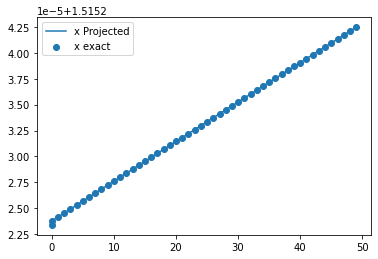

In [13]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=2.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=2.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30


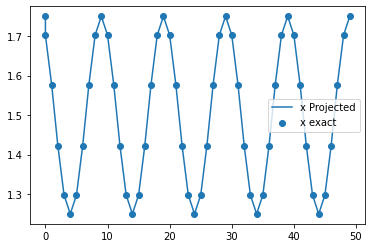

In [14]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30


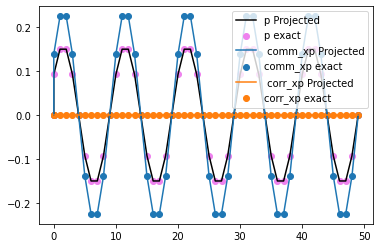

In [15]:
## usando n_body_basis(2) y el estado no gaussiano de Mauricio

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)
plt.plot(results["ts"], results["averages"][:,1], label="p Projected", color = "black")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact", color = "violet")
plt.legend()

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,2], label=" comm_xp Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,2], label="comm_xp exact")

## ---- ## 

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,3], label=" corr_xp Projected")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,3], label="corr_xp exact")

plt.legend()

sampling: 30
sampling: 30


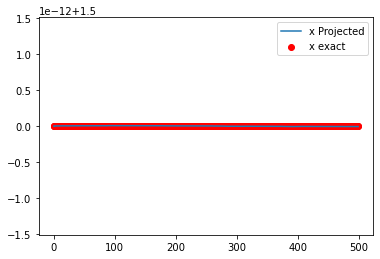

In [18]:
## Ahora testeemos un estado 1-max-ent y veamos que da 

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact", color="red")
#print(results)
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30


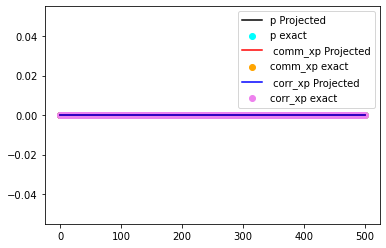

In [19]:
## Ahora testeemos un estado 2-max-ent

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=True)

plt.plot(results["ts"], results["averages"][:,1], label="p Projected", color="black")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact", color="cyan")
#print(results)
plt.legend()

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,2], label=" comm_xp Projected", color="red")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,2], label="comm_xp exact", color="orange")

## ---- ## 

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,3], label=" corr_xp Projected", color = "blue")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,3], label="corr_xp exact", color = "violet")

plt.legend()

sampling: 30
sampling: 30


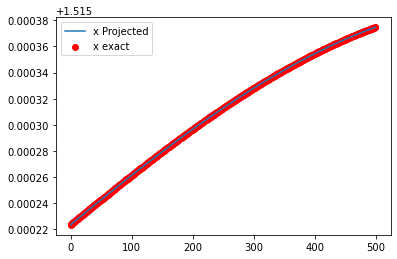

In [16]:
## Ahora testeemos un estado 2-max-ent y veamos que da

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact", color="red")
#print(results)
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30


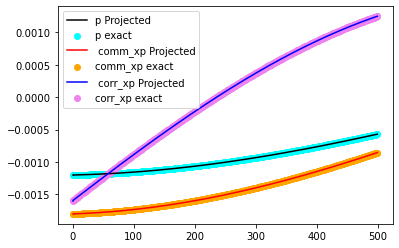

In [17]:
## Ahora testeemos un estado 2-max-ent

results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=True)

plt.plot(results["ts"], results["averages"][:,1], label="p Projected", color="black")
results = projected_evolution(author = True, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact", color="cyan")
#print(results)
plt.legend()

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,2], label=" comm_xp Projected", color="red")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,2], label="comm_xp exact", color="orange")

## ---- ## 

results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,3], label=" corr_xp Projected", color = "blue")
results = projected_evolution(author = True, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,3], label="corr_xp exact", color = "violet")

plt.legend()

sampling: 30
sampling: 30


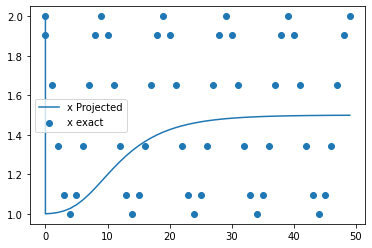

In [29]:
## Que pasa si uso una 1-base

results = projected_evolution(author = False, x=.999, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,0], label="x Projected")
results = projected_evolution(author = False, x=.999, gamma = 1*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=False, gr = None, deltat=1, tmax = 50, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,0], label="x exact")
plt.legend()

sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30
sampling: 30


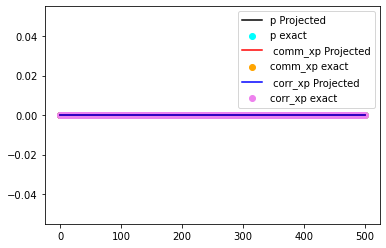

In [31]:
## Ahora testeemos un estado 2-max-ent

results = projected_evolution(author = False, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=True)

plt.plot(results["ts"], results["averages"][:,1], label="p Projected", color="black")
results = projected_evolution(author = False, x=None, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures, do_project=False)
plt.scatter(results["ts"], results["averages"][:,1], label="p exact", color="cyan")
#print(results)
plt.legend()

results = projected_evolution(author = False, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,2], label=" comm_xp Projected", color="red")
results = projected_evolution(author = False, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,2], label="comm_xp exact", color="orange")

## ---- ## 

results = projected_evolution(author = False, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=True)

plt.plot(results["ts"], results["averages"][:,3], label=" corr_xp Projected", color = "blue")
results = projected_evolution(author = False, x=.5, gamma = 1*np.e*-10, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 1, deltat=1, tmax = 500, 
                              distance=me.bures,do_project=False)
plt.scatter(results["ts"], results["averages"][:,3], label="corr_xp exact", color = "violet")

plt.legend()

In [123]:
HS_modified = True

class Result(object):
      def __init__(self, ts=None, states=None):
        self.ts = ts
        self.states = states
        self.projrho0_app = None   
        self.projrho_inst_app = None 

def callback(t, rhot):
    global rho
    rho = rhot

# Algunos problemas que tiene el problema cómo está planteado ahora:
    # * rho0 debería ser un estado descorrelacionado. Aquí estamos estando el estado inicial,
    #   que es un estado entrelazado
    # * El estado inicial no pertenece a la variedad Max-Ent: Para que esto funcione, deberíamos, o bien proyectar el estado inicial a la variedad,
    # o bien agregar el log(rho0) a la base de operadores. 
    
def projected_evolution(author=True,x=.5, gamma = 1*np.e*-2, omega_1=3., omega_2=3.,temp=1, 
                        gaussian=False, gr = int, deltat=10., tmax = 500., distance=me.bures, 
                        do_project=True):
    global rho
    loc_globalid = qutip.tensor([qutip.qeye(2) for k in range(N)])

    if (gaussian and gr == 1):
        coeffs_me1_gr1 = [[10**-1,2*10**-1],[np.pi*10**-1,10**-18],
                          [10**-18,10**-18],[10**-18,10**-18]]
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me1_gr1, None)
        
    elif(gaussian and gr == 2):
        a = len(me.all_two_body_spin_ops(N))
        b = len(me.all_two_body_spin_ops(N)[0])

        coeffs_me2_gr2 = 10**-1 * np.full((a,b),1.)
        rho0 = me.initial_state(N, gaussian, gr, None, coeffs_me2_gr2, None)
        
    elif(not gaussian):
        rho0 = me.initial_state(N, gaussian, gr, x, None, psi0)
         
    if author: 
        basis = me.base_orth(me.n_body_basis(2, N), rho0)  ## // Á la Tom
    else:
        basis = me.base_orth(me.n_body_basis(1, N), rho0)
        
    obs = [x_op, p_op, comm_xp, corr_xp]
          #, x_op**2,p_op**2, corr_op, p_dot]
        
    entropyVN = []
    def callback_entropy(t, rhot):
        entropyVN.append(qutip.entropy_vn(rhot))
        
    sampling = max(int(10*max(1,omega_1, omega_2)*deltat), 10)
    print("sampling:", sampling)
    c_op_list = me.spin_dephasing(N,gamma)
    rho = rho0                                                               ## // Á la Mauricio
    approx_exp_vals = [[qutip.expect(op, rho) for op in obs]]
    ts= [0]

    for i in range(int(tmax/deltat)):
        qutip.mesolve(H=H_H, 
                               rho0=rho, 
                               tlist=np.linspace(0,deltat, sampling), 
                               c_ops=c_op_list, 
                               e_ops=callback_entropy,
                               args={'gamma': gamma,'omega_1': omega_1, 'omega_2': omega_2}
                               )
        ts.append(deltat*i)
        if do_project:
            rho = me.proj_op(me.logM(rho), basis, rho0)
            #rho = me.proj_op(me.logM(rho), basis, loc_globalid)
            e0 = max(rho.eigenenergies())
            rho = rho - loc_globalid * e0
            rho = rho.expm()
            trrho = (2.*rho.tr())
            rho = (rho+rho.dag())/trrho

        #print(qutip.entropy.entropy_vn(rho))
        newobs = [qutip.expect(rho, op) for op in obs]
        approx_exp_vals.append(newobs)

    result = {}
    result["ts"] = ts
    result["averages"] = entropyVN
    #np.array(approx_exp_vals)
    
    title = f" BW Dinámica cerrada no gaussiana wb1={omega_1} wb2={omega_2}" 
    if do_project:
        title = title + "_projected_"

    with open(title+".pkl","wb") as f:
        pickle.dump(result, f)
    return entropyVN

sampling: 120


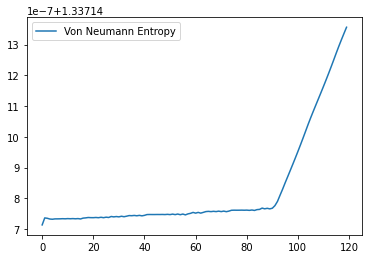

In [128]:
results = projected_evolution(author = True, x=None, gamma = 5*np.e*-1, omega_1=3., omega_2=3.,
                              temp=1, gaussian=True, gr = 2, deltat=4, tmax = 5, 
                              distance=me.bures, do_project=False)

plt.plot(results, label="Von Neumann Entropy")
plt.legend()

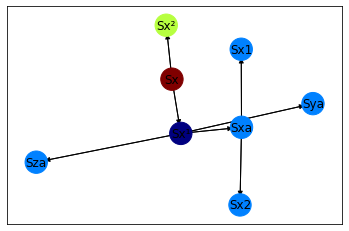

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_edges_from(
    [('Sx', 'Sx¹'), ('Sx', 'Sx²'), ('Sx¹', 'Sxa'), ('Sx¹', 'Sya'), ('Sx¹', 'Sza'), ('Sxa', 'Sx1'), ('Sxa', 'Sx2') ])

val_map = {'Sx': 1.0,
           'Sx²': 0.5714285714285714,
           'Sx¹': 0.0}

values = [val_map.get(node, 0.25) for node in G.nodes()]

# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = values, node_size = 500)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, arrows=True)
nx.draw_networkx_edges(G, pos, arrows=False)
plt.show()


In [132]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.7.0
Numpy,1.22.4
SciPy,1.8.1
matplotlib,3.5.2
Cython,0.29.30
Number of CPUs,6
BLAS Info,Generic
IPython,8.3.0
Python,"3.10.4 (main, Mar 31 2022, 08:41:55) [GCC 7.5.0]"
OS,posix [linux]


In [131]:
!pip install Cython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.0 MB/s eta 0:00:000m eta 0:00:010:00:01
